<a href="https://colab.research.google.com/github/ascarrambad/ml-21-22/blob/main/08_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sun Spot Forecasting

**Author:** [Vedang Naik](https://www.linkedin.com/in/vedangnaik/)<br>
**Date created:** 2020/06/12<br>
**Last modified:** 2020/07/22<br>




## Forecasting sunspots

![](https://upload.wikimedia.org/wikipedia/commons/4/47/Solar_Archipelago_-_Flickr_-_NASA_Goddard_Photo_and_Video.jpg)

As a case study we will consider the problem of forecasting the number of **sunspots** using a dataset collected by the solar physics research department of the Royal Observatory of Belgium ([link](http://sidc.oma.be/)).

According to Wikipedia:

> Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

The datset is avaiable on Kaggle ([link](https://www.kaggle.com/robervalt/sunspots)) and frequently updated.

For simplicity (and reproducibility), we loaded a snapshot of the dataset in the repo of the course.

We start by installing the last version of statsmodels.

In [1]:
%pip install statsmodels -U

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/ascarrambad/ml-21-22/main/data/sunspots.csv"

df = pd.read_csv(url,
                 parse_dates=True,
                 index_col='Date',
                 usecols=['Date', 'Monthly Mean Total Sunspot Number'])
df = df.rename(columns={'Monthly Mean Total Sunspot Number':'sunspots'})

Let's have a look at the data!

Text(0, 0.5, 'n. sunspots')

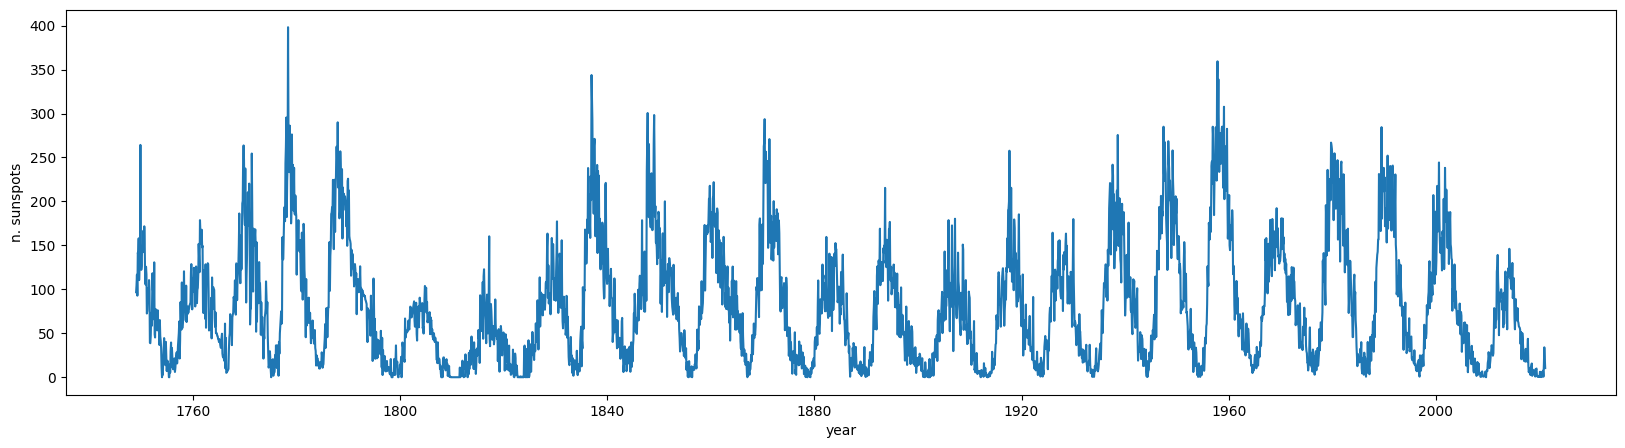

In [3]:
plt.figure(figsize=(20,5))
plt.plot(df.index, df['sunspots'])
plt.xlabel('year')
plt.ylabel('n. sunspots')

First of all let's split our data for model evaluation.

In [4]:
from sklearn.model_selection import train_test_split

# NB: DO NOT SHUFFLE THE DATA!!
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)

# scale the data

mean = train_df.values.mean()
std = train_df.values.std()

scale = lambda x : (x - mean) / std
inv_scale = lambda x : x * std + mean

train_df = scale(train_df)
test_df = scale(test_df)

## A simple baseline

Simply use the value at the previous time-step to predict the next one.

BASELINE MSE: 636.9892484662575
BASELINE MAE: 18.23021472392638


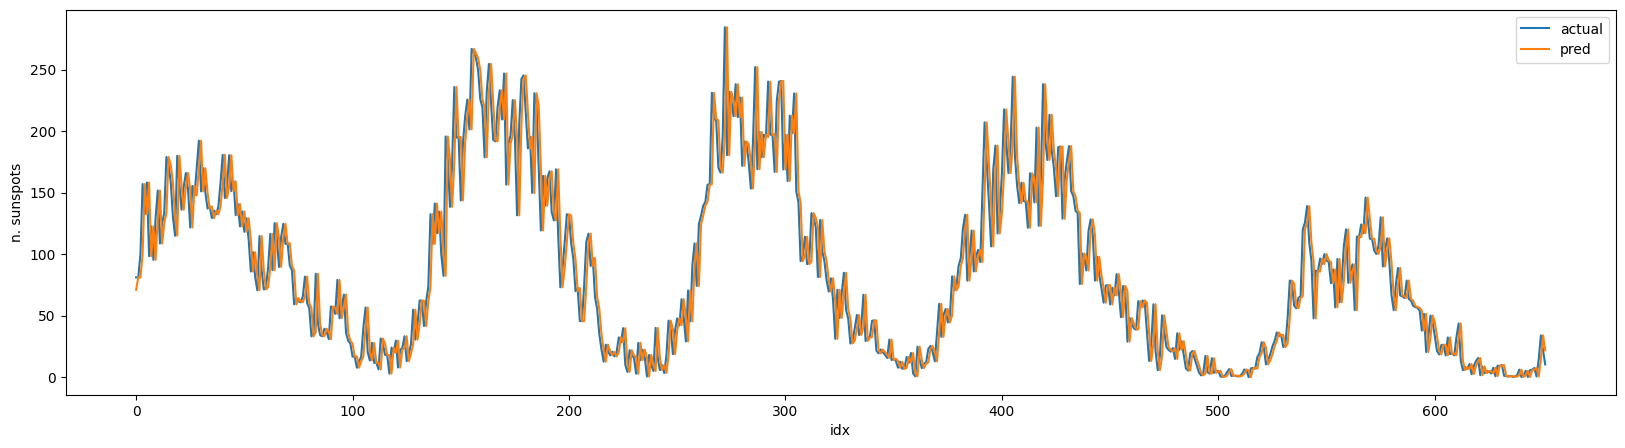

In [5]:
actuals = inv_scale(test_df.values.ravel())

mse = np.square(actuals[:-1] - actuals[1:]).mean()
print(f"BASELINE MSE: {mse}")
mae = np.abs(actuals[:-1] - actuals[1:]).mean()
print(f"BASELINE MAE: {mae}")


plt.figure(figsize=(20, 5))
plt.plot(actuals[1:], label='actual')
plt.plot(actuals[:-1], label='pred')
plt.xlabel('idx')
plt.ylabel('n. sunspots')
plt.legend()

### Linear models

Let's start with an AR model.

In [6]:
from statsmodels.tsa.arima.model import ARIMA

#ARIMA(p,i,q)
model = ARIMA(train_df, order=(3, 0, 0), trend='n')

fit = model.fit()
print(fit.summary())

# appends test_df to avaiable data
fit = fit.append(test_df, refit=False)

actuals = test_df.values.ravel()
preds = fit.predict(start=len(train_df)).values.ravel()

mse = np.square(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"TEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(actuals)).mean()
print(f"TEST MAE: {mae}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               sunspots   No. Observations:                 2612
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1201.162
Date:                Mon, 22 Jan 2024   AIC                           2410.323
Time:                        12:12:46   BIC                           2433.795
Sample:                    01-31-1749   HQIC                          2418.826
                         - 08-31-1966                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6119      0.014     42.412      0.000       0.584       0.640
ar.L2          0.1483      0.017      8.792      0.000       0.115       0.181
ar.L3          0.1886      0.015     12.603      0.0

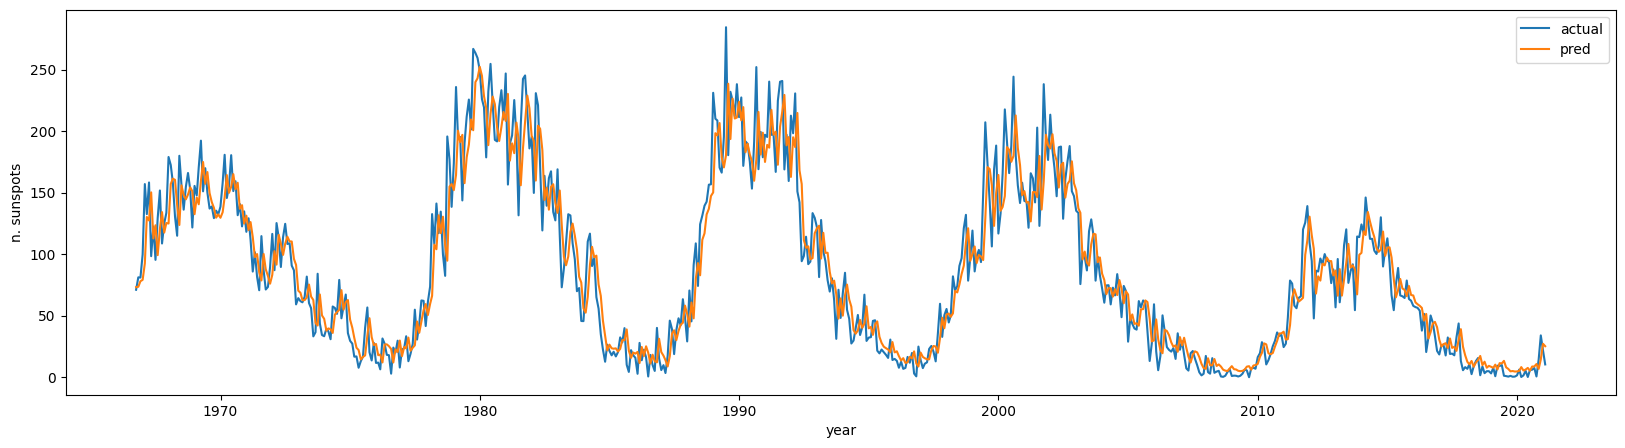

In [7]:
preds = fit.predict(start=len(train_df), dynamic=False)

plt.figure(figsize=(20, 5))
plt.plot(inv_scale(test_df), label='actual')
plt.plot(inv_scale(preds), label='pred')
plt.xlabel('year')
plt.ylabel('n. sunspots')

plt.legend()

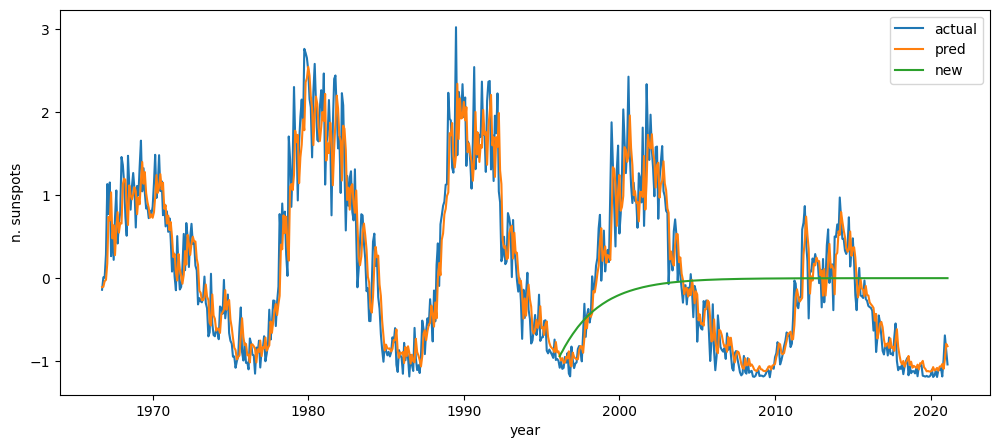

In [8]:
# one-step prediction
y_pred = fit.predict(start=len(train_df), dynamic=False)

# recursie prediction
n_last = 300
y_new = fit.predict(start=len(train_df) + len(test_df) - n_last, dynamic=True)

plt.figure(figsize=(12, 5))
plt.plot(test_df, label="actual")
plt.plot(y_pred, label="pred")
plt.plot(y_new, label="new")
plt.xlabel('year')
plt.ylabel('n. sunspots')
plt.legend()

## Nonlinear Autoregressive models

### Let's divide data into windows

```
            historical data                   | future observations
--------------------------------------------------------------------
x(1) x(2) ... x(t-p) x(t-p+1) ... x(t-1) x(t) | x(t+1)  x(t+2) ...
                    \________________________/| \____/
                       time window            | value to
                                              | be predicted
```

In [9]:
# Time windows
def get_time_windows(sequence, window_size):
    time = np.arange(sequence.shape[0])
    xseq = []
    yseq = []
    for t in time[:-window_size]:
        xseq.append(sequence[t:t+window_size])
        yseq.append(sequence[t+window_size])
    xseq = np.array(xseq)
    yseq = np.array(yseq)
    #train-test split
    return xseq, yseq.ravel()


In [10]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)
print("training data", x_train.shape, y_train.shape)
print("test data", x_test.shape, y_test.shape)

training data (2588, 24) (2588,)
test data (629, 24) (629,)


We can use the usual syntax to build a neural network with keras and train it to predict the next value in the time-series.

We can formulate it as a regression problem.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape

# Build a model
def get_model(win_size):
    model = Sequential()
    model.add(Dense(64, activation="relu", input_shape=(win_size,)))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse")
    return model

In [12]:
# Prepare the data
p = 24

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)

# Train the model
model = get_model(p)
model.fit(x_train, y_train, epochs=50)

preds = model.predict(x_test).ravel()

mse = np.square(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mse}")
mae = np.abs(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MAE: {mae}")

Epoch 1/50
81/81 [==============================] - 5s 5ms/step - loss: 0.3369
Epoch 2/50
81/81 [==============================] - 0s 5ms/step - loss: 0.1633
Epoch 3/50
81/81 [==============================] - 0s 6ms/step - loss: 0.1496
Epoch 4/50
81/81 [==============================] - 0s 5ms/step - loss: 0.1430
Epoch 5/50
81/81 [==============================] - 0s 4ms/step - loss: 0.1421
Epoch 6/50
81/81 [==============================] - 0s 5ms/step - loss: 0.1380
Epoch 7/50
81/81 [==============================] - 0s 4ms/step - loss: 0.1334
Epoch 8/50
81/81 [==============================] - 0s 4ms/step - loss: 0.1340
Epoch 9/50
81/81 [==============================] - 0s 4ms/step - loss: 0.1300
Epoch 10/50
81/81 [==============================] - 0s 4ms/step - loss: 0.1298
Epoch 11/50
81/81 [==============================] - 0s 5ms/step - loss: 0.1281
Epoch 12/50
81/81 [==============================] - 0s 3ms/step - loss: 0.1281
Epoch 13/50
81/81 [==============================

20/20 [==============================] - 0s 1ms/step


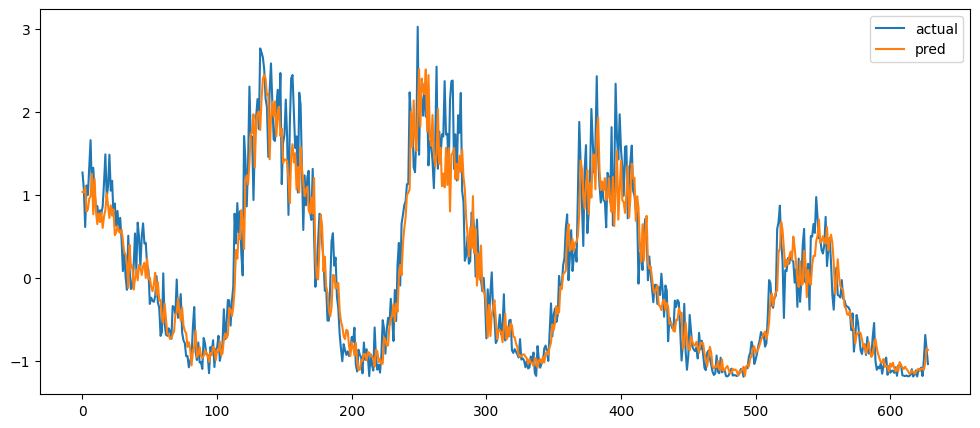

In [13]:
# Predictions
y_pred = model.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="actual")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="pred")
plt.legend()

It looks like that the NAR model is not very good.

Let's see what happens with recursive predictions.

In [14]:
# Predict on our prediction
def predict_rec(n, model, x_init):
    p = x_init.shape[0]

    y_new = np.zeros(p+n)
    y_new[:p] = x_init.copy()

    for j in range(n):
        y_tmp = model.predict(y_new[j:j+p][None, ...])
        y_new[j+p] = y_tmp[-1,0]
    return y_new[p:]

1/1 [==============================] - 0s 16ms/step


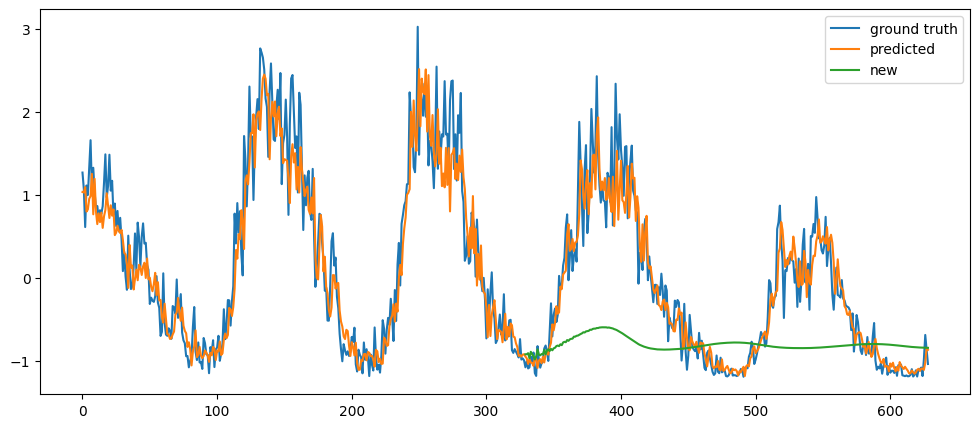

In [15]:
# one-step prediction
y_pred = model.predict(x_test)

# one-step prediction
n_last = 300
y_new = predict_rec(n=n_last, model=model, x_init=x_test[-n_last-1])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="ground truth")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="predicted")
plt.plot(np.arange(y_test.shape[0]-n_last, y_test.shape[0]), y_new, label="new")
plt.legend()

## Recurrent neural networks

Finally let's try out a more advanced architecture: LSTM networks.

Implementing LSTMs is again easy with keras.

In [16]:
from tensorflow.keras.layers import LSTM, Reshape

# Build a model
def get_model(win_size):
    model = Sequential()
    model.add(Reshape((-1, 1), input_shape=(None,))) # [batch, time, features]
    model.add(LSTM(16))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer="adam", loss="mse")
    return model

In [17]:
# Prepare the data
p = 150

x_train, y_train = get_time_windows(sequence=train_df.values.ravel(), window_size=p)
x_test, y_test = get_time_windows(sequence=test_df.values.ravel(), window_size=p)

# Train the model
model = get_model(p)
model.fit(x_train, y_train, epochs=50)

preds = model.predict(x_test).ravel()

mse = np.square(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mse}")

mae = np.abs(inv_scale(preds) - inv_scale(y_test)).mean()
print(f"TEST MSE: {mae}")

Epoch 1/50
77/77 [==============================] - 3s 8ms/step - loss: 0.6660
Epoch 2/50
77/77 [==============================] - 1s 7ms/step - loss: 0.2162
Epoch 3/50
77/77 [==============================] - 0s 6ms/step - loss: 0.1695
Epoch 4/50
77/77 [==============================] - 1s 7ms/step - loss: 0.1533
Epoch 5/50
77/77 [==============================] - 1s 7ms/step - loss: 0.1478
Epoch 6/50
77/77 [==============================] - 1s 9ms/step - loss: 0.1426
Epoch 7/50
77/77 [==============================] - 1s 9ms/step - loss: 0.1412
Epoch 8/50
77/77 [==============================] - 1s 9ms/step - loss: 0.1404
Epoch 9/50
77/77 [==============================] - 1s 9ms/step - loss: 0.1384
Epoch 10/50
77/77 [==============================] - 1s 8ms/step - loss: 0.1366
Epoch 11/50
77/77 [==============================] - 1s 7ms/step - loss: 0.1342
Epoch 12/50
77/77 [==============================] - 0s 6ms/step - loss: 0.1334
Epoch 13/50
77/77 [==============================

16/16 [==============================] - 0s 4ms/step


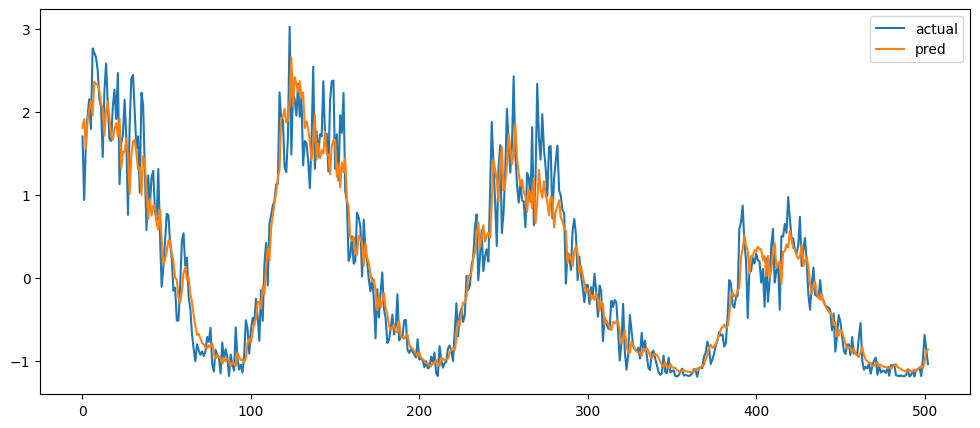

In [18]:
# Predictions
y_pred = model.predict(x_test)

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="actual")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="pred")
plt.legend()

In [19]:
# Predict on our prediction
def predict_rec(n, model, x_init):
    p = x_init.shape[0]

    y_new = np.zeros(p+n)
    y_new[:p] = x_init.copy()

    for j in range(n):
        y_tmp = model.predict(y_new[:j+p][None, ...])  # the rnn can handle sequences of arbitrary lenght
        y_new[j+p] = y_tmp[-1,0]
    return y_new[p:]

1/1 [==============================] - 0s 20ms/step


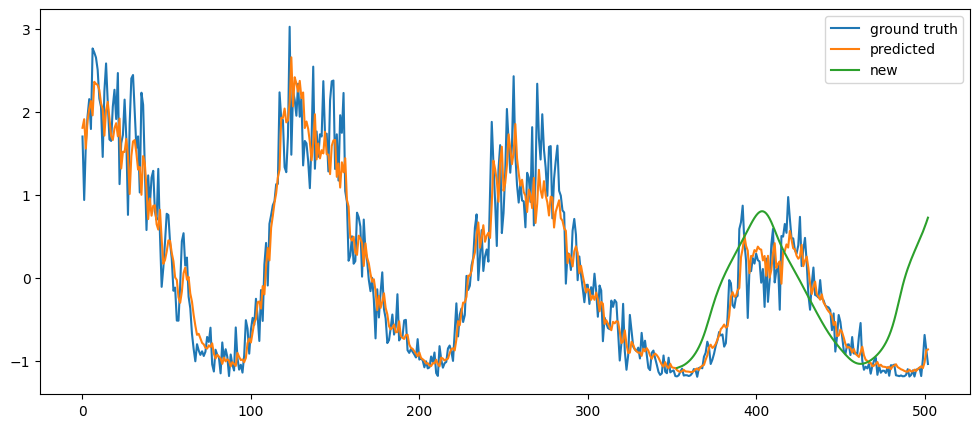

In [20]:
# one-step prediction
y_pred = model.predict(x_test)

# one-step prediction
n_last = 150
y_new = predict_rec(n=n_last, model=model, x_init=x_test[-n_last-1])

plt.figure(figsize=(12, 5))
plt.plot(np.arange(y_test.shape[0]), y_test, label="ground truth")
plt.plot(np.arange(y_test.shape[0]), y_pred, label="predicted")
plt.plot(np.arange(y_test.shape[0]-n_last, y_test.shape[0]), y_new, label="new")
plt.legend()